In [1]:
import tensorflow as tf
from keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # GPU 列表

G = 1 # GPU 数量
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 200 # 问题/答案 上限200个词
MAX_NB_WORDS = 20000 # 字典 上限20000个词
EMBEDDING_DIM = 100 # 100d 词向量

### 数据预处理

In [3]:
import json
import jieba

train_path = 'data/train_data_sample.json'
with open(train_path, 'r') as f:
    train = json.load(f)

questions = []
answers = []
labels = []
for item in train:
    q = ' '.join(jieba.cut(item['question']))
    for passage in item['passages']:
        a = ' '.join(jieba.cut(passage['content']))
        questions.append(q)
        answers.append(a)
        labels.append(passage['label'])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.886 seconds.
Prefix dict has been built succesfully.


In [4]:
# https://keras-cn-docs.readthedocs.io/zh_CN/latest/blog/word_embedding/
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenizer
texts = questions + answers
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# sequences
sequences_q = tokenizer.texts_to_sequences(questions)
sequences_a = tokenizer.texts_to_sequences(answers)

# padding
data_q = pad_sequences(sequences_q, maxlen=MAX_SEQUENCE_LENGTH)
data_a = pad_sequences(sequences_a, maxlen=MAX_SEQUENCE_LENGTH)

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data_q.shape)
print('Shape of data tensor:', data_a.shape)

Found 221387 unique tokens.
Shape of data tensor: (80084, 200)
Shape of data tensor: (80084, 200)


In [5]:
import pickle

token_path = 'model/token/tokenizer.pkl'
pickle.dump(tokenizer, open(token_path, 'wb'))

### 网络结构

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional

QA_EMBED_SIZE = 64
DROPOUT_RATE = 0.3

q = Sequential()
q.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
q.add(Bidirectional(LSTM(QA_EMBED_SIZE, return_sequences=False), merge_mode="sum"))
q.add(Dropout(DROPOUT_RATE))

a = Sequential()
a.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
a.add(Bidirectional(LSTM(QA_EMBED_SIZE, return_sequences=False), merge_mode="sum"))
a.add(Dropout(DROPOUT_RATE))

model = Sequential()
model.add(Merge([q, a], mode='sum'))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 44,446,625
Trainable params: 44,446,625
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


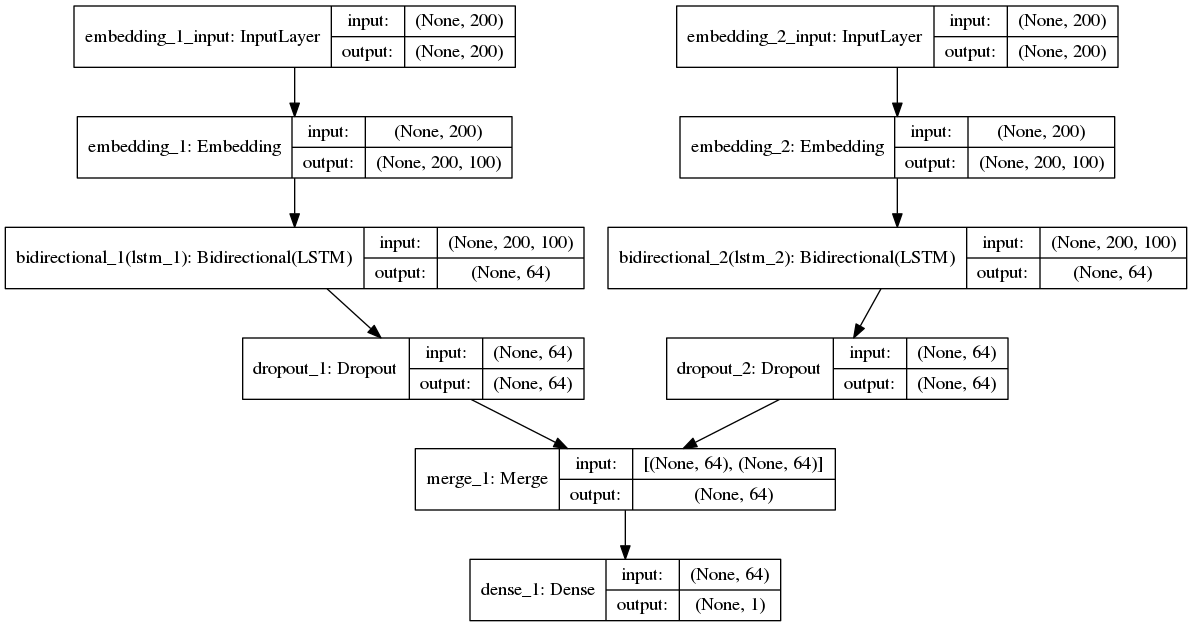

In [7]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot=1.2.3
# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file="img/model-blstm.png", show_shapes=True)
display.Image('img/model-blstm.png')

### 训练

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import multi_gpu_model

EPOCHS = 5
BATCH_SIZE = 64 * G
VALIDATION_SPLIT = 0.1 # 10% 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'model/model-blstm.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard('log/tflog-blstm', write_graph=True, write_images=True)

# model = multi_gpu_model(model)

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.fit([data_q, data_a], labels, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VALIDATION_SPLIT, shuffle=True, 
          callbacks=[early_stopping, model_checkpoint, tensorboard])

Train on 72075 samples, validate on 8009 samples
Epoch 1/5
72075/72075 [==============================] - 1166s 16ms/step - loss: 0.5105 - acc: 0.7538 - val_loss: 0.5239 - val_acc: 0.7453
Epoch 2/5
72075/72075 [==============================] - 1206s 17ms/step - loss: 0.4039 - acc: 0.8170 - val_loss: 0.5654 - val_acc: 0.7312
Epoch 3/5
72075/72075 [==============================] - 1165s 16ms/step - loss: 0.3152 - acc: 0.8635 - val_loss: 0.6596 - val_acc: 0.7226
Epoch 4/5
72075/72075 [==============================] - 1168s 16ms/step - loss: 0.2322 - acc: 0.9040 - val_loss: 0.7116 - val_acc: 0.7085
Epoch 5/5
72075/72075 [==============================] - 1166s 16ms/step - loss: 0.1667 - acc: 0.9340 - val_loss: 1.0027 - val_acc: 0.7017


### 预测

In [9]:
# load tokenizer
# token_path = 'model/tokenizer.pkl'
# tokenizer = pickle.load(open(token_path, 'rb'))

# load model
model_path = 'model/model-blstm.h5'
model.load_weights(model_path)

# load test data
test_path = 'data/test_data_sample.json'
with open(test_path, 'r') as f:
    test = json.load(f)

questions = []
answers = []
ids = []
for item in test:
    q = ' '.join(jieba.cut(item['question']))
    for passage in item['passages']:
        a = ' '.join(jieba.cut(passage['content']))
        questions.append(q)
        answers.append(a)
        ids.append(passage['passage_id'])

In [10]:
sequences_q = tokenizer.texts_to_sequences(questions)
sequences_a = tokenizer.texts_to_sequences(answers)

test_q = pad_sequences(sequences_q, maxlen=MAX_SEQUENCE_LENGTH)
test_a = pad_sequences(sequences_a, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', test_q.shape)
print('Shape of data tensor:', test_a.shape)

Shape of data tensor: (1586, 200)
Shape of data tensor: (1586, 200)


In [11]:
predicts = model.predict([test_q, test_a], batch_size=64, verbose=1)

with open('predict/predict-blstm.txt', 'w') as f:
    for i in range(len(ids)):
        f.write('%d,%s\n' % (ids[i], predicts[i][0]))

1586/1586 [==============================] - 7s 4ms/step
